## Procesamiento de Lenguaje Natural: Clasificación de textos

### 1. Importar las librerías

In [43]:
import pandas as pd
import numpy as np
import nltk
import re
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
import spacy
from unidecode import unidecode
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import fasttext
from sklearn.model_selection import train_test_split
import fasttext

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score

import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
pl.__version__

'1.7.7'

### 2. Lectura de datos

In [3]:
data = pd.read_excel('dataset-augmented-joined-fixed-with-id.xlsx')

### 3. Preprocesamiento de datos

#### 3.1. Normalización del texto

In [4]:
nlp = spacy.load('es_core_news_sm')
wpt = nltk.WordPunctTokenizer()
stop_words = nlp.Defaults.stop_words

def normalize_document(doc):
    # Utilizar Spacy para tokenizar, eliminar acentos y transformar a minúsculas
   # remueve acentos: 
    doc = unidecode(doc)
    # remueve caracteres especiales: 
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) 
    # re.I ignore si es mayúscula o minúscula; re.A solamente caracteres ASCII
    # transforma a minúsculas
    doc = doc.lower()
    # remueve espacios en blanco en los extremos
    doc = doc.strip()
    tokens = wpt.tokenize(doc) #[token.text for token in doc if not token.is_punct]
    
    # Filtrar las palabras vacías
    filtered_tokens = [token for token in tokens \
                       if token not in stop_words \
                      and len(token) > 2]
    
    # Reunir los tokens en un solo documento
    doc = ' '.join(filtered_tokens)
    
    return doc

/home/melibuntu/.cache/pypoetry/virtualenvs/app-QoKfD4mD-py3.8/lib/python3.8/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [5]:
data['text_procesado'] = data['pregunta'].map(normalize_document)

In [6]:
data['text_procesado'].to_csv('text_procesado_unal.txt')

#### 3.2. Train/test split

In [11]:
# Supongamos que tienes un DataFrame llamado 'data' con columnas 'features' y 'target'.
X = data['text_procesado'].values  # Características
y = data['respuesta_id'].values    # Objetivos

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Puedes ajustar el valor de 'test_size' para controlar la proporción de datos en el conjunto de prueba.
# 'random_state' se utiliza para garantizar la reproducibilidad de la división, puedes cambiar su valor.

# Imprime las longitudes de los conjuntos de entrenamiento y prueba
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de prueba:", len(X_test))

Tamaño del conjunto de entrenamiento: 3197
Tamaño del conjunto de prueba: 800


#### 3.4. Representaciones vectoriales de palabras a partir de un corpus de texto

In [12]:
path = 'text_representation_total_unal.ftz'

try:
    model_ft = fasttext.load_model(path)
except:
    model_ft = fasttext.train_unsupervised("text_procesado_unal.txt", model='skipgram')
    model_ft.save_model(path)

In [13]:
# Paso 2: Representa tus textos como vectores utilizando el modelo entrenado
X_train_fasttext = [model_ft.get_sentence_vector(text) for text in X_train]
X_test_fasttext = [model_ft.get_sentence_vector(text) for text in X_test]

X_train_fasttext = np.array(X_train_fasttext)
X_test_fasttext = np.array(X_test_fasttext)

In [14]:
X_total = [model_ft.get_sentence_vector(text) for text in X]
X_total_fasttext = np.array(X_total)

### 4. Modelos
#### 4.1. Multilayer Perceptron

In [15]:
pl.__version__

'1.7.7'

In [16]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

class TextClassificationModel(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers, dropout):
        super(TextClassificationModel, self).__init__()
        self.apply(init_weights)
        self.input_layer = nn.Linear(input_dim, hidden_dim)  # Capa de entrada
        self.hidden_layers = nn.ModuleList()
        
        # Agrega capas ocultas con Dropout
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(p=dropout))  # Añade una capa de Dropout con probabilidad dropout_prob
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)  # Capa de entrada

        for layer in self.hidden_layers:
            x = layer(x)
        x = self.fc_out(x)
        return x

    def optimizer(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-8, weight_decay=1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

# Ajusta los hiperparámetros
input_dim = X_train_fasttext.shape[1]
hidden_dim = 512
output_dim = len(data['respuesta_id'].unique())
num_hidden_layers = 10
dropout = 0.5  # Probabilidad de Dropout del 50%
# Crea una instancia del modelo con los nuevos hiperparámetros

model_mlp = TextClassificationModel(input_dim, hidden_dim, output_dim, num_hidden_layers, dropout)

# Crear un DataLoader personalizado
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #print(idx)
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = TextDataset(X_train_fasttext, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TextDataset(X_test_fasttext, y_test)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Configuración del entrenamiento
num_epochs = 100
trainer = pl.Trainer(max_epochs=num_epochs)  # Si tienes una GPU disponible, puedes habilitarla aquí

avg_train_loss = []
avg_val_loss = []

# Entrenamiento
for epoch in tqdm(range(trainer.max_epochs)):
    model_mlp.train()
    total_loss = 0
    num_batches = len(train_loader)

    for batch in train_loader:
        x, y = batch
        model_mlp.optimizer().zero_grad()

        y_hat = model_mlp(x)
        #print(y_hat.shape)
        y_hat_soft = nn.functional.softmax(y_hat, dim=1)
        loss = nn.CrossEntropyLoss()(y_hat_soft, y.long())
        total_loss += loss.item()
        
        loss.backward(retain_graph = True)
        model_mlp.optimizer().step()
    
    avg_loss = total_loss / num_batches
    avg_train_loss.append(avg_loss)

    model_mlp.eval()
    total_val_loss = 0
    num_val_batches = len(val_loader)
    
    for batch in val_loader:
        x, y = batch
        model_mlp.optimizer().zero_grad()
        y_hat = model_mlp(x)
        y_hat_soft = nn.functional.softmax(y_hat, dim=1)
        val_loss = nn.CrossEntropyLoss()(y_hat_soft, y.long())
        total_val_loss += val_loss.item()
        
        #loss.backward(retain_graph=True)
        #model.optimizer().step()

    avg_val_loss.append(total_val_loss / num_val_batches)

# Evaluación del modelo
model_mlp.eval()
y_pred_mlp = []

with torch.no_grad():
    for batch in val_loader:
        x, _ = batch
        y_hat = model_mlp(x)
        y_hat_soft = nn.functional.softmax(y_hat, dim=1)
        y_pred_mlp.extend(y_hat_soft.argmax(dim=1).cpu().numpy())

accuracy = accuracy_score(y_test, y_pred_mlp)
print(f'Accuracy on test data: {accuracy}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
100%|██████████| 100/100 [02:22<00:00,  1.43s/it]

Accuracy on test data: 0.0


#### Training/Test Loss Plot

Text(0.5, 0, 'Epoch')

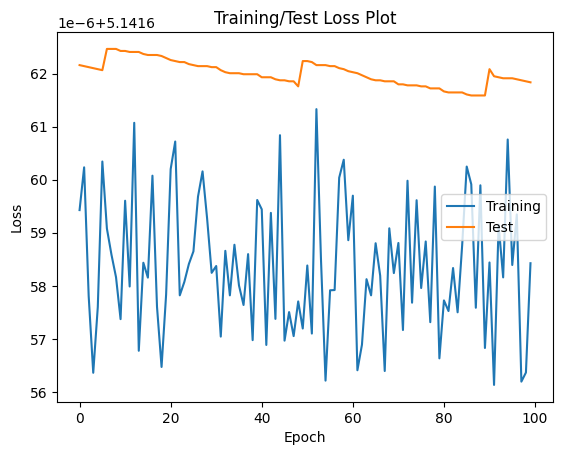

In [17]:
epocas = np.arange(num_epochs)
plt.plot(epocas, avg_train_loss, label = 'Training')
plt.plot(epocas, avg_val_loss, label = 'Test')
plt.legend()

plt.title('Training/Test Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')

#### Prueba del chatbot

In [20]:
def chatbot_mlp(pregunta):
    x = model_ft.get_sentence_vector(normalize_document(pregunta))
    x = torch.Tensor(x)
    y = model_mlp(x).argmax().item()
    respuesta = data[data['respuesta_id'] == y]['respuesta'].values[0]

    print('respuesta',respuesta)

In [21]:
pregunta = input('Hola! ¿En qué te puedo ayudar hoy? ')
chatbot_mlp(pregunta)

Hola! ¿En qué te puedo ayudar hoy?  carreras


respuesta Las pruebas específicas son instrumentos que permiten identificar el nivel de afinidad con los aspectos propios de la asimilación, interpretación y producción artisitica.


#### 4.2. Convolutional Neural Network

In [23]:
# Definición de la arquitectura de la CNN
class TextCNNModel(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, num_classes, num_filters, filter_sizes, dropout):
        super(TextCNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def optimizer(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)  # Ajusta la tasa de aprendizaje según sea necesario
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

# Ajusta los hiperparámetros
vocab_size = X_train_fasttext.shape[1]  # Reemplaza 'vocab' con tu propio vocabulario
embedding_dim = 50  # Dimensión de los vectores de palabras pre-entrenados
num_classes = len(data['respuesta_id'].unique())
num_filters = 100
filter_sizes = [3, 4, 5]  # Tamaños de los filtros convolucionales
dropout = 0.5  # Probabilidad de Dropout del 50%

# Crea una instancia del modelo de CNN
model_cnn = TextCNNModel(vocab_size, embedding_dim, num_classes, num_filters, filter_sizes, dropout)

# Configura los conjuntos de datos y los DataLoaders (ya los tienes configurados)

# Crear un DataLoader personalizado
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #print(idx)
        return self.X[idx], self.y[idx]

batch_size = 64
train_dataset = TextDataset(X_train_fasttext, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TextDataset(X_test_fasttext, y_test)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Configuración del entrenamiento
num_epochs = 100
trainer = pl.Trainer(max_epochs=num_epochs)  # Si tienes una GPU disponible, puedes habilitarla aquí

avg_train_loss = []
avg_val_loss = []

# Entrenamiento
for epoch in tqdm(range(trainer.max_epochs)):
    model_cnn.train()
    total_loss = 0
    num_batches = len(train_loader)

    for batch in train_loader:
        x, y = batch
        model_cnn.optimizer().zero_grad()

        y_hat = model_cnn(x.long())
        #print(y_hat.shape)
        y_hat_soft = nn.functional.softmax(y_hat, dim=1)
        loss = nn.CrossEntropyLoss()(y_hat_soft, y.long())
        total_loss += loss.item()
        
        loss.backward(retain_graph = True)
        model_cnn.optimizer().step()
    
    avg_loss = total_loss / num_batches
    avg_train_loss.append(avg_loss)

    model_cnn.eval()
    total_val_loss = 0
    num_val_batches = len(val_loader)
    
    for batch in val_loader:
        x, y = batch
        model_cnn.optimizer().zero_grad()
        y_hat = model_cnn(x.long())
        y_hat_soft = nn.functional.softmax(y_hat, dim=1)
        val_loss = nn.CrossEntropyLoss()(y_hat_soft, y.long())
        total_val_loss += val_loss.item()
        
        #loss.backward(retain_graph=True)
        #model.optimizer().step()

    avg_val_loss.append(total_val_loss / num_val_batches)

# Evaluación del modelo
model_cnn.eval()
y_pred_cnn = []

with torch.no_grad():
    for batch in val_loader:
        x, _ = batch
        y_hat = model_cnn(x.long())
        y_hat_soft = nn.functional.softmax(y_hat, dim=1)
        y_pred_cnn.extend(y_hat_soft.argmax(dim=1).cpu().numpy())

accuracy = accuracy_score(y_test, y_pred_cnn)
print(f'Accuracy on test data: {accuracy}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
100%|██████████| 100/100 [01:16<00:00,  1.31it/s]

Accuracy on test data: 0.03375


#### Training/Test Loss Plot

Text(0.5, 0, 'Epoch')

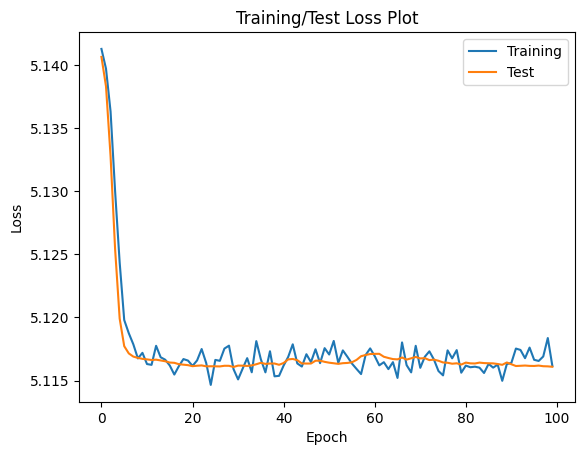

In [24]:
epocas = np.arange(num_epochs)
plt.plot(epocas, avg_train_loss, label = 'Training')
plt.plot(epocas, avg_val_loss, label = 'Test')

plt.legend()

plt.title('Training/Test Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')

#### Prueba del chatbot

In [31]:
def chatbot_cnn(pregunta):
    x = model_ft.get_sentence_vector(normalize_document(pregunta))
    x = torch.Tensor(x).reshape(1,100)
    y = model_cnn(x.long()).argmax().item()
    respuesta = data[data['respuesta_id'] == y]['respuesta'].values[0]

    print(f'respuesta',respuesta)

In [33]:
pregunta = input('Hola! ¿En qué te puedo ayudar hoy? ')
chatbot_cnn(pregunta)

Hola! ¿En qué te puedo ayudar hoy?  carreras


respuesta Aspirante, tenga en cuenta que dada las condiciones actuales impuestas por el COVID-19, el proceso de evaluación de aspirantes a pregrado se realizará a partir de los resultados de la Prueba Saber 11.
 
Durante el proceso de inscripción a la Universidad, el aspirante deberá diligenciar el número del Registro SNP y el número y tipo de documento con el que presentó la prueba Saber 11 que empleará en el proceso de admisión a la Universidad Nacional de Colombia. La prueba debe haber sido presentada a partir del 2014-2 toda vez que, de acuerdo con el ICFES, las pruebas aplicadas a partir de ese periodo son comparables.

El puntaje de admisión con el cual participará el aspirante será calculado por la Universidad Nacional de Colombia a partir de los puntajes de las pruebas de Matemáticas (PMA), Lectura Crítica (PLC), Sociales y Ciudadanas (PSC) y Ciencias Naturales (PCN) de la Prueba Saber 11. El modelo del cálculo del puntaje de admisión se encuentra publicado en la página web de 

#### 4.3. Recurrent Neural Network

In [34]:
# Definición de la arquitectura de la RNN
class TextRNNModel(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers, dropout):
        super(TextRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Utiliza la salida de la última capa de la secuencia
        return out

    def optimizer(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)  # Ajusta la tasa de aprendizaje según sea necesario
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

# Ajusta los hiperparámetros
vocab_size = X_train_fasttext.shape[1]   # Reemplaza 'vocab' con tu propio vocabulario
embedding_dim = 100  # Dimensión de los vectores de palabras pre-entrenados
hidden_dim = 256  # Dimensión de las capas ocultas de la RNN
num_classes = len(data['respuesta_id'].unique())
num_layers = 2  # Número de capas de la RNN
dropout = 0.5  # Probabilidad de Dropout del 50%

# Crea una instancia del modelo de RNN
model_rnn = TextRNNModel(vocab_size, embedding_dim, hidden_dim, num_classes, num_layers, dropout)

# Configura los conjuntos de datos y los DataLoaders (ya los tienes configurados)

# Crear un DataLoader personalizado
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #print(idx)
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = TextDataset(X_train_fasttext, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TextDataset(X_test_fasttext, y_test)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Configuración del entrenamiento
num_epochs = 100
trainer = pl.Trainer(max_epochs=num_epochs)  # Si tienes una GPU disponible, puedes habilitarla aquí

avg_train_loss = []
avg_val_loss = []

# Entrenamiento
for epoch in tqdm(range(trainer.max_epochs)):
    model_rnn.train()
    total_loss = 0
    num_batches = len(train_loader)

    for batch in train_loader:
        x, y = batch
        model_rnn.optimizer().zero_grad()

        y_hat = model_rnn(x.long())
        #print(y_hat.shape)
        y_hat_soft = nn.functional.softmax(y_hat, dim=1)
        loss = nn.CrossEntropyLoss()(y_hat_soft, y.long())
        total_loss += loss.item()
        
        loss.backward(retain_graph = True)
        model_rnn.optimizer().step()
    
    avg_loss = total_loss / num_batches
    avg_train_loss.append(avg_loss)

    model_rnn.eval()
    total_val_loss = 0
    num_val_batches = len(val_loader)
    
    for batch in val_loader:
        x, y = batch
        model_rnn.optimizer().zero_grad()
        y_hat = model_rnn(x.long())
        y_hat_soft = nn.functional.softmax(y_hat, dim=1)
        val_loss = nn.CrossEntropyLoss()(y_hat_soft, y.long())
        total_val_loss += val_loss.item()
        
        #loss.backward(retain_graph=True)
        #model.optimizer().step()

    avg_val_loss.append(total_val_loss / num_val_batches)

# Evaluación del modelo
model_rnn.eval()
y_pred_rnn = []

with torch.no_grad():
    for batch in val_loader:
        x, _ = batch
        y_hat = model_rnn(x.long())
        y_hat_soft = nn.functional.softmax(y_hat, dim=1)
        y_pred_rnn.extend(y_hat_soft.argmax(dim=1).cpu().numpy())

accuracy = accuracy_score(y_test, y_pred_rnn)
print(f'Accuracy on test data: {accuracy}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
100%|██████████| 100/100 [13:59<00:00,  8.39s/it]


Accuracy on test data: 0.03375


#### Training/Test Loss Plot

Text(0.5, 0, 'Epoch')

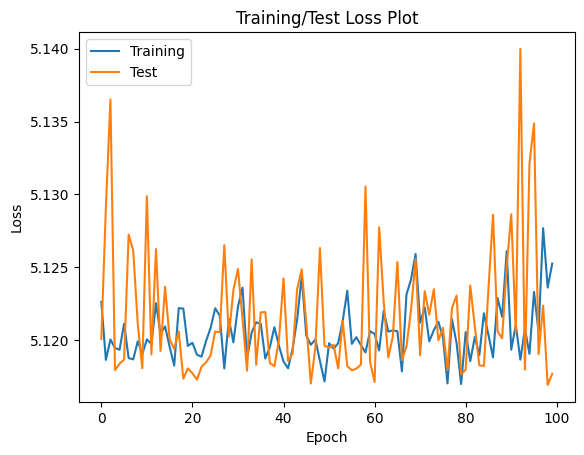

In [35]:
epocas = np.arange(num_epochs)
plt.plot(epocas, avg_train_loss, label = 'Training')
plt.plot(epocas, avg_val_loss, label = 'Test')

plt.legend()

plt.title('Training/Test Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')

#### Prueba del chatbot

In [36]:
def chatbot_rnn(pregunta):
    x = model_ft.get_sentence_vector(normalize_document(pregunta))
    x = torch.Tensor(x).reshape(1,100)

    y = model_rnn(x.long()).argmax(dim = 1).item()
    
    respuesta = data[data['respuesta_id'] == y]['respuesta'].values[0]

    print('respuesta',respuesta)

In [37]:
pregunta = input('Hola! En qué puedo ayudarte hoy? ')
chatbot_rnn(pregunta)

Hola! En qué puedo ayudarte hoy?  carreras


respuesta Aspirante, tenga en cuenta que dada las condiciones actuales impuestas por el COVID-19, el proceso de evaluación de aspirantes a pregrado se realizará a partir de los resultados de la Prueba Saber 11.
 
Durante el proceso de inscripción a la Universidad, el aspirante deberá diligenciar el número del Registro SNP y el número y tipo de documento con el que presentó la prueba Saber 11 que empleará en el proceso de admisión a la Universidad Nacional de Colombia. La prueba debe haber sido presentada a partir del 2014-2 toda vez que, de acuerdo con el ICFES, las pruebas aplicadas a partir de ese periodo son comparables.

El puntaje de admisión con el cual participará el aspirante será calculado por la Universidad Nacional de Colombia a partir de los puntajes de las pruebas de Matemáticas (PMA), Lectura Crítica (PLC), Sociales y Ciudadanas (PSC) y Ciencias Naturales (PCN) de la Prueba Saber 11. El modelo del cálculo del puntaje de admisión se encuentra publicado en la página web de 

#### 4.4. XGBoost

In [38]:
X_train_fasttext.shape

(3197, 100)

In [39]:
y_train.shape

(3197,)

In [40]:
# 3. Entrenamiento del modelo XGBoost
model_xg = xgb.XGBClassifier()
model_xg.fit(X_train_fasttext, y_train, verbose = True)

# Predicciones en el conjunto de prueba
y_pred_xg = model_xg.predict(X_test_fasttext)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred_xg)
print(f'Accuracy on test data: {accuracy}')

Accuracy on test data: 0.4975


#### Prueba chatbot

In [41]:
def chatbot_xgboost(pregunta):
    x = model_ft.get_sentence_vector(normalize_document(pregunta))
    y = model_xg.predict(np.array([x]))[0]
    
    respuesta = data[data['respuesta_id'] == y]['respuesta'].values[0]

    print('respuesta',respuesta)

In [42]:
pregunta = input('Hola! En qué puedo ayudarte hoy?')
chatbot_xgboost(pregunta)

Hola! En qué puedo ayudarte hoy? carreras


respuesta En el momento de realizar la inscripción en la página web admisiones.unal.edu.co, podrá indicar hasta tres carreras de acuerdo a su prioridad.


### 5. Métricas

In [44]:
# Calcular y comparar métricas
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
accuracy_xg = accuracy_score(y_test, y_pred_xg)

precision_mlp = precision_score(y_test, y_pred_mlp, average = 'weighted')
precision_cnn = precision_score(y_test, y_pred_cnn,  average = 'weighted')
precision_rnn = precision_score(y_test, y_pred_rnn,  average = 'weighted')
precision_xg = precision_score(y_test, y_pred_xg,  average = 'weighted')

recall_mlp = recall_score(y_test, y_pred_mlp, average = 'weighted')
recall_cnn = recall_score(y_test, y_pred_cnn,  average = 'weighted')
recall_rnn = recall_score(y_test, y_pred_rnn,  average = 'weighted')
recall_xg = recall_score(y_test, y_pred_xg,  average = 'weighted')

# Imprimir las métricas
print("Exactitud (Accuracy):")
print(f"Multilayer Perceptron: {accuracy_mlp}")
print(f"Convolutional Neural Network: {accuracy_cnn}")
print(f"Recurrent Neural Network: {accuracy_rnn}")
print(f"XGBoost: {accuracy_xg}")

# Imprimir las métricas
print("\nPrecisión (Precision):")
print(f"Multilayer Perceptron: {precision_mlp}")
print(f"Convolutional Neural Network: {precision_cnn}")
print(f"Recurrent Neural Network: {precision_rnn}")
print(f"XGBoost: {precision_xg}")

# Imprimir las métricas
print("\nSensitividad (Recall):")
print(f"Multilayer Perceptron: {recall_mlp}")
print(f"Convolutional Neural Network: {recall_cnn}")
print(f"Recurrent Neural Network: {recall_rnn}")
print(f"XGBoost: {recall_xg}")

Exactitud (Accuracy):
Multilayer Perceptron: 0.0
Convolutional Neural Network: 0.03375
Recurrent Neural Network: 0.03375
XGBoost: 0.4975

Precisión (Precision):
Multilayer Perceptron: 0.0
Convolutional Neural Network: 0.0011390625
Recurrent Neural Network: 0.0011390625
XGBoost: 0.5084826982297378

Sensitividad (Recall):
Multilayer Perceptron: 0.0
Convolutional Neural Network: 0.03375
Recurrent Neural Network: 0.03375
XGBoost: 0.4975


/home/melibuntu/.cache/pypoetry/virtualenvs/app-QoKfD4mD-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/melibuntu/.cache/pypoetry/virtualenvs/app-QoKfD4mD-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/melibuntu/.cache/pypoetry/virtualenvs/app-QoKfD4mD-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

### Fasttext

In [46]:
data['label'] = '__label__' + data['respuesta_id'].astype(float).astype(int).astype(str) + ' ' + data['text_procesado'].astype(str)

X = data['label'].values  # Características

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [47]:
data_train = pd.DataFrame({'label': X_train})

data_train.to_csv('datos_train_unal_fastext.txt', index = False, header = False)

data_test = pd.DataFrame({'label': X_test})

data_test.to_csv('datos_test_unal_fastext.txt', index = False, header = False)

In [48]:
!head datos_train_unal_fastext.txt

__label__71 debo inscribirme examen suficiencia ingles procedimiento
__label__30 precio carrera medicina
__label__161 ubicacion rendir examen exterior
__label__166 procedimiento devolucion pin utilice convocatoria
__label__161 restriccion estudiantes extranjeros proceso admision
__label__101 necesario indigena participar programa comunidades indigenas
__label__30 costo estudiar medicina
__label__47 algun costo asociado solicitud admision
__label__47 universidad ofrece servicios apoyo estudiantes discapacidad visual
__label__31 acceso codigo icfes colegio


In [49]:
try:
    model_ft_clas = fasttext.load_model('modelo_fasttext_class.ftz')
except:
    model_ft_clas = fasttext.train_supervised(input='datos_train_unal_fastext.txt', 
                                              autotuneValidationFile='datos_test_unal_fastext.txt')
    model_ft_clas.save_model('modelo_fasttext_class.ftz')

In [50]:
model_ft_clas.test('datos_test_unal_fastext.txt')

(800, 0.78, 0.78)

In [54]:
model_ft_clas.test_label('datos_test_unal_fastext.txt')

{'__label__150': {'precision': 1.0, 'recall': nan, 'f1score': 2.0},
 '__label__154': {'precision': 1.0, 'recall': nan, 'f1score': 2.0},
 '__label__16': {'precision': 1.0, 'recall': nan, 'f1score': 2.0},
 '__label__65': {'precision': 1.0, 'recall': nan, 'f1score': 2.0},
 '__label__24': {'precision': 0.8, 'recall': nan, 'f1score': 1.6},
 '__label__122': {'precision': 1.0, 'recall': nan, 'f1score': 2.0},
 '__label__144': {'precision': 1.0, 'recall': nan, 'f1score': 2.0},
 '__label__133': {'precision': 0.6666666666666666,
  'recall': nan,
  'f1score': 1.3333333333333333},
 '__label__14': {'precision': 0.3333333333333333,
  'recall': nan,
  'f1score': 0.6666666666666666},
 '__label__45': {'precision': 0.0, 'recall': nan, 'f1score': 0.0},
 '__label__12': {'precision': 1.0, 'recall': nan, 'f1score': 2.0},
 '__label__170': {'precision': 1.0, 'recall': nan, 'f1score': 2.0},
 '__label__116': {'precision': 1.0, 'recall': nan, 'f1score': 2.0},
 '__label__146': {'precision': 1.0, 'recall': nan, 'f1

#### Prueba del chatbot

In [78]:
def chatbot_ft(pregunta):
    y = model_ft_clas.predict(pregunta)[0][0][9:]
    y = int(y)
    
    respuesta = data[data['respuesta_id'] == y]['respuesta'].values[0]

    print('respuesta',respuesta)

In [79]:
pregunta = input('Hola! En qué puedo ayudarte hoy?')
chatbot_ft(pregunta)

Hola! En qué puedo ayudarte hoy? peama


respuesta Respuesta para aspirantes interesados en ingresar a un programa curricular de pregrado:

Atendiendo a su solicitud se informa que según lo establecido en el Artículo 6 de la Resolución 55 de 2016 de Rectoría, "Por la cual se reglamenta para el Programa Especial de Admisión y Movilidad Académica (PEAMA) de Presencia Nacional, la admisión, la matrícula inicial para admitidos, la región de influencia para las Sedes Amazonia, Caribe, Orinoquia y Tumaco y los estímulos económicos para el personal académico de la Universidad Nacional de Colombia y se deroga la Resolución 887 de 2015 de la Rectoría": “Los aspirantes a ser admitidos dentro del Programa Especial de Admisión y Movilidad Académica (PEAMA) de Presencia Nacional de la Universidad Nacional de Colombia, deberán cumplir con los dos requisitos siguientes:

a.        Haber cursado los dos últimos años de bachillerato (educación media) en un colegio que se encuentre ubicado dentro de la región de influencia de la Sede de Presen